# PDE-FIND za gušeni klasični harmonijski oscilator

Vinko Dragušica, 2022.

Predstavljen je kod koji pomoću modula PDE-FIND iz danih podataka otkriva jednadžbu koja opisuje dinamiku gušenog klasičnog harmonijskog oscilatora za $\zeta=0.2$.
$$
u_{tt} + 2\zeta u_t + u = 0
$$

In [1]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import sys; sys.path.append('../')
from PDE_FIND_CM import *
import itertools

In [2]:
import pandas
df = pandas.read_csv('../Datasets/GuseniOscPodatci.csv', skiprows=1, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.944308,1.778412,2.478276,3.026976,3.414805,3.639099,3.703789,3.618736,3.398889,...,-0.113284,-0.093973,-0.07249,-0.049842,-0.027004,-0.004884,0.015709,0.03409,0.049712,0.062179


In [3]:
u = df.to_numpy()
x = [0]
t = np.linspace(0,20,100)
dt = t[1]-t[0]
#dx = x[1]-x[0]

Text(0, 0.5, 'u(t)')

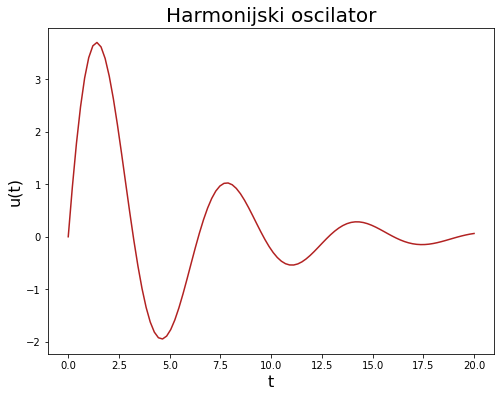

In [4]:
fig1 = plt.figure(figsize=(8,6))
plt.plot(t,u[0,:],color='firebrick')
plt.title('Harmonijski oscilator', fontsize = 20)
plt.xlabel('t', fontsize = 16)
plt.ylabel('u(t)', fontsize = 16)

## Konstruiramo $\Theta (U)$ i računamo $U_t$:

Konstruiramo funkcije koje će se nalaziti u $\Theta$. Također specificiramo njihove opise i na kraju pomoću build_Theta konstruiramo $\Theta$ koji ćemo koristiti kasnije. <br>
time_diff i space_diff izračunati su pomoću metode konačnih razlika (funkcija FiniteDiff()).

Ispisana je lista funkcija kandidata za PDJ. Svaka od ispisanih funkcija ekvivalentna je stupcu u $\Theta (U)$.

In [5]:
m = len(x)
n = len(t)

ut = np.zeros((m,n), dtype=np.complex64)
utt = np.zeros((m,n), dtype=np.complex64)
sin_t = np.zeros((m,n), dtype=np.complex64)
cos_t = np.zeros((m,n), dtype=np.complex64)
exp_t = np.zeros((m,n), dtype=np.complex64)

for i in range(m):
    ut[i,:] = FiniteDiff(u[i,:], dt, 1)
    utt[i,:] = FiniteDiff(u[i,:], dt, 2) # koristi se kasnije kod funkcije TrainSTRidge
    sin_t[i,:] = np.sin(t)
    cos_t[i,:] = np.cos(t)
    exp_t[i,:] = np.e**t

ut = np.reshape(ut, (n*m,1), order='F')
utt = np.reshape(utt, (n*m,1), order='F')

X_ders = np.hstack([np.ones((n*m,1)),ut])
X_data = np.hstack([np.reshape(u, (n*m,1), order='F'),
                    np.reshape(sin_t, (n*m,1), order='F'),
                    np.reshape(cos_t, (n*m,1), order='F'),
                    np.reshape(exp_t, (n*m,1), order='F')])
derivatives_description = ['','u_t']

X, descr = build_Theta(X_data, X_ders, derivatives_description, P=1, data_description = ['u','sin(t)','cos(t)','e^t'])
descr

['',
 'u_t',
 'e^t',
 'cos(t)',
 'sin(t)',
 'u',
 'e^tu_t',
 'cos(t)u_t',
 'sin(t)u_t',
 'uu_t']

## Računamo $\xi$:

TrainSTRidge dijeli podatke na dio za trening (80% ukupnih podataka) i dio za validaciju (20% ukupnih podataka). Algoritam traži optimalnu vrijednost za varijablu tol (tolerancija ispod koje zanemarujemo varijablu) i odabire toleranciju provjerom na validacijskom skupu, uključujući i $\ell^0$ penalizaciju za $\xi$ u funkciji gubitka.

In [6]:
# Solve with STRidge
w = TrainSTRidge(X,utt,10**-5,0.1)
print("PDJ dobivena pomoću STRidge:")
print_pde(w, descr)

PDJ dobivena pomoću STRidge:
u_tt = (-0.404290 +0.000000i)u_t
    + (-0.995693 +0.000000i)u
   


In [7]:
err = abs(np.array([(0.4 -  0.404290)/0.4*100, (1 -  0.995693)*100]))
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:\n")
print("Srednja greška parametara:", np.mean(err), '%')
print("Standardna devijacija srednje greške parametara:", np.std(err), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:

Srednja greška parametara: 0.7515999999999925 %
Standardna devijacija srednje greške parametara: 0.3208999999999975 %
